# **Building a Small Language Model**


# **Stage One - Building the LLM**
This Stage Consists of 3 Parts:
1. Data Preparation and Sampling
2. Attention Mechanisms
3. LLM Architecture

## Part 1 - *Data Preparation & Sampling*
Formatting and preparing the data into the necessary form to be processed and understood by the neural network.

### All Imports Needed

In [1]:
import torch.nn as nn
from matplotlib.ticker import MaxNLocator
import torch
import matplotlib.pyplot as plt

### Importing the Dataset Example
In our case, we will be using the pdf form of the book "The Verdict"

In [2]:
import urllib.request
url = ("https://raw.githubusercontent.com/rasbt/"
       "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
       "the-verdict.txt")
file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x154a4c3dfd0>)

In [3]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
  raw_text = f.read()
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


### Creating the Tokenizer

#### Step 1: Creating Tokens

In [4]:
# Use regular expressions to create tokens.
# We want to filter out whiite spaces and special characters.
import re

preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
print(preprocessed[:50])

# Will filter out any whitespaces and only return the characters.
preprocessed = [item for item in preprocessed if item.strip()]
print(preprocessed[:50])

['I', ' ', 'HAD', ' ', 'always', ' ', 'thought', ' ', 'Jack', ' ', 'Gisburn', ' ', 'rather', ' ', 'a', ' ', 'cheap', ' ', 'genius', '--', 'though', ' ', 'a', ' ', 'good', ' ', 'fellow', ' ', 'enough', '--', 'so', ' ', 'it', ' ', 'was', ' ', 'no', ' ', 'great', ' ', 'surprise', ' ', 'to', ' ', 'me', ' ', 'to', ' ', 'hear', ' ']
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in', 'the', 'height', 'of', 'his', 'glory', ',', 'he', 'had', 'dropped', 'his', 'painting', ',', 'married', 'a', 'rich', 'widow', ',', 'and', 'established', 'himself']


#### Step 2: Determining the Vocabulary and mapping them to their token IDs


In [5]:
# Creating our Vocabulary of unique tokens (Alphabetically Arranged)
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

vocab = {token:integer for integer,token in enumerate(all_words)}

# Print first 50 vocab elements
for i, item in enumerate(vocab.items()):
  print(item)
  if i >= 50:
    break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


In [6]:
vocab = {token:integer for integer, token in enumerate(all_words)}

for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


In [7]:
"""
SimpleTokenizerV1 - A simple tokenizer that can perform encoding and decoding.

SimpleTokenizerV2 - Replaces Uknown words with the special character <|unk|> and
unrelated pieces of texts with <|endoftext|>

"""
class SimpleTokenizerV1:
    def __init__(self, vocab):
      self.str_to_int = vocab
      self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
      preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
      preprocessed = [
      item.strip() for item in preprocessed if item.strip()
      ]
      ids = [self.str_to_int[s] for s in preprocessed]
      return ids

    def decode(self, ids):
      text = " ".join([self.int_to_str[i] for i in ids])

      text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
      return text

In [8]:
class SimpleTokenizerV2:
  def __init__(self, vocab):
    self.str_to_int = vocab
    self.int_to_str = { i:s for s,i in vocab.items()}

  def encode(self, text):
    preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
    preprocessed = [
    item.strip() for item in preprocessed if item.strip()
    ]

    preprocessed = [item if item in self.str_to_int
                else "<|unk|>" for item in preprocessed]
    ids = [self.str_to_int[s] for s in preprocessed]
    return ids

  def decode(self, ids):
    text = " ".join([self.int_to_str[i] for i in ids])
    text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
    return text

##### Create Byte-Pair Encoder
- Is a subword tokenization algorithm. The most common pair of consecutive bytes of data is replaced with a byte that does not occur in data.

Advantages:
- Byte-pair encoding can reduce the size of the vocabulary significantly.
- The BPE tokenizer can handle any unknown word without needing the `<|unk|>` token.

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [10]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text)) # Prints the new number of tokens using the GPT2 tokenizer

5145


In [11]:
# To better visualize what's being done

enc_sample = enc_text[50:]
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
z = enc_sample[2:context_size+2]
print(f"x: {x}")
print(f"y:      {y}")
print(f"z:            {z}")
print("------------------------------------")

# Representation: left side = input, right side = target
for i in range(1, context_size+1):
  context = enc_sample[:i]
  desired = enc_sample[i]
  print(context, "---->", desired)
  print(tokenizer.decode(context), "---->", tokenizer.decode([desired])) # Text equivalent
  print("")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]
z:            [2241, 287, 257, 4489]
------------------------------------
[290] ----> 4920
 and ---->  established

[290, 4920] ----> 2241
 and established ---->  himself

[290, 4920, 2241] ----> 287
 and established himself ---->  in

[290, 4920, 2241, 287] ----> 257
 and established himself in ---->  a



In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

# Dataset Implementation
class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []

    # Tokenizes the entire text
    token_ids = tokenizer.encode(txt)

    # Uses a sliding window approach to chunk the book into overlapping sequences.
    for i in range(0, len(token_ids) - max_length, stride):
      input_chunk = token_ids[i:i + max_length]
      target_chunk = token_ids[i + 1: i + max_length + 1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]

#-------------------------------------------------------------------------------

# Dataloader Implementation
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                 stride=128, shuffle=True, drop_last=True,
                 num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2") # Instantiates the gpt2 tokenizer

    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)  # Initialize the Dataset class created earlier

      # Intantiates and provides parameters for the DataLoader python class provided by PyTorch.
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [13]:
# Test
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    dataloader = create_dataloader_v1(
      raw_text, batch_size=2, max_length=6, stride=6, shuffle=False)
    data_iter = iter(dataloader)  # Creates an Iterator
    first_batch = next(data_iter) # Gets the next batch from the data Iterator, the first_batch will be assigned a tuple of tensors.
    print(first_batch)

[tensor([[   40,   367,  2885,  1464,  1807,  3619],
        [  402,   271, 10899,  2138,   257,  7026]]), tensor([[  367,  2885,  1464,  1807,  3619,   402],
        [  271, 10899,  2138,   257,  7026, 15632]])]


In [14]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[15632,   438,  2016,   257,   922,  5891],
        [ 1576,   438,   568,   340,   373,   645]]), tensor([[ 438, 2016,  257,  922, 5891, 1576],
        [ 438,  568,  340,  373,  645, 1049]])]


#### Step 3: Mapping Token Embeddings --- COME BACK TO THIS!

##### Import Trained Model

In [15]:
#  !pip install gensim
# import gensim.downloader as api
# model = api.load("word2vec-google-news-300")

##### Positional Embedding Implementation


In [16]:
# These are the inputs that we'll be using, with their embeddings, given that each word has 3 dimensions. 
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your    
   [0.55, 0.87, 0.66], # journey 
   [0.57, 0.85, 0.64], # starts  
   [0.22, 0.58, 0.33], # with    
   [0.77, 0.25, 0.10], # one     
   [0.05, 0.80, 0.55]] # step    
)

In [17]:
"""
The Embedding function only requires the vocab_size
as it'll provide random embeddings originally
and those embeddings will be adjusted over training.
"""

vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

token_embeddings = token_embedding_layer(inputs.long())
print(token_embeddings.shape)

# Instantiating the data loader
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
   stride=max_length, shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

torch.Size([6, 3, 256])
Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [18]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [19]:
#! [[TODO]] SIZE INCOMPATABILITY BETWEEN TOKEN AND POSITIONAL EMBEDDINGS
# input_embeddings = token_embeddings + pos_embeddings
# print(input_embeddings.shape)

## Part 2 - *ATTENTION MECHANISM*
There are 4 kinds of attention mechanisms and we will be implementing each one until we arrive to the original </br>
transformer's **"Multi-Head Self-Attention"** mechanism, building on top of the previous implementation and ideas.

### First Implementation: **Simplified Attention Mechanism**

#### Compute Attention Scores - 2nd input example

In [20]:
query = inputs[1] # Takes 'journey' as the query.
attention_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
  attention_scores_2[i] = torch.dot(x_i, query) 

print(attention_scores_2)

tensor([ 2956967., 16597455., 29439276., 30712224., 23737832.,  2581577.,
        23769278., 12535636.])


#### Compute Attention Weights

In [21]:
attention_weights_2_tmp = attention_scores_2 / attention_scores_2.sum()

print("Attention weights: ", attention_weights_2_tmp)
print("Sum: ", attention_weights_2_tmp.sum())

Attention weights:  tensor([0.0208, 0.1166, 0.2068, 0.2158, 0.1668, 0.0181, 0.1670, 0.0881])
Sum:  tensor(1.)


In [22]:
'''
The following is a naive Softmax Implementation. However, this implementation has weaknesses when dealing with very small or large values.
Therefore it is recommended to simply use PyTorch's implmentation of Softmax.
''' 

def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attention_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())



Attention weights: tensor([nan, nan, nan, nan, nan, nan, nan, nan])
Sum: tensor(nan)


In [23]:
# PyTorch Softmax Function Implementation, results in same value of previous softmax function.
attn_weights_2 = torch.softmax(attention_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0., 0., 0., 1., 0., 0., 0., 0.])
Sum: tensor(1.)


#### Compute Context Vectors
The context vector z is the weighted sum of all input vectors, obtained by multiplying each input vector by its corresponding attention weight:

In [24]:
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += attention_weights_2_tmp[i]*x_i #x_i is simply the input vector, multiplying with its corresponding attention weights.

print(context_vec_2)

tensor([6203.2407, 3242.1980,  940.7390, 1740.2675])


#### A Generalised Approach
So far, for the attention mechanism built above, we have implemented attention with respect to the embeddings vector of the second input. Now we will create a generalised method that can be applied to all embeddings vectors.

#### Generalized Process
We perform the same 3 steps performed prior, with a few modifications.

In [25]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your    
   [0.55, 0.87, 0.66], # journey 
   [0.57, 0.85, 0.64], # starts  
   [0.22, 0.58, 0.33], # with    
   [0.77, 0.25, 0.10], # one     
   [0.05, 0.80, 0.55]] # step    
)

In [26]:
attention_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, j_i in enumerate(inputs):
        attention_scores[i, j] = torch.dot(x_i, j_i)

print(attention_scores) # Unnormalized output

""" 
!
The issue with the above implementation is that cause of the nested for loop
it is slow and computationally expensive, a better approach can be done with linear algebra.
"""

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


' \n!\nThe issue with the above implementation is that cause of the nested for loop\nit is slow and computationally expensive, a better approach can be done with linear algebra.\n'

In [27]:
"""
The following method is more efficient, not because the time complexity is any less,
but the implementation time is far less, the time it takes to perform each multiplication, the '@' symbol represents matrix multiplication.
You get the exact same answer as the previous method, but much faster.
"""

attention_scores = inputs @ inputs.T
print(attention_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


#### Calculating the Attention Weights

In [28]:
'''
Declaring the dimensions to be -1 will normally apply the normalization to the last dimension, however, for a 2 dimensional tensor,
the dim = -1 will apply the Softmax into all columns.
'''
attention_weights = torch.softmax(attention_scores, dim=-1) #
print(attention_weights)

# To verify that all rows sum up to 1
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("----------------------------------------------------------------")
print("Row 2 sum:", row_2_sum)
print("All row sums:", attention_weights.sum(dim=-1))

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])
----------------------------------------------------------------
Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


#### Computing the Context Vectors

In [29]:
# Simply a matrix multiplication is performed. Concluding the generalised method of calculating context vectors.
all_context_vec = attention_weights @ inputs
print(all_context_vec)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


### Second Implementation: **Self-Attention**
This self-attention mechanism is also called *scaled dot-product attention*. 
<br>We will be building on top of our last model, this time introducing **Trainable Weight Matrices**. This can help the model to produce better context vectors.

For illustration purposes, we will be computing for only one context vector, *z(2)*.
- Note that in GPT-like models, the input and output dimensions are usually the same,
 but to better follow the computation, we’ll use different input (d_in=3) and output
 (d_out=2) dimensions here.

In [30]:
# Initializing variables dealing with the second input
x_2 = inputs[1]    
d_in = inputs.shape[1]     
d_out = 2 

 Initialize the query, key, and value matrices of the second input "journey".

In [31]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [32]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

tensor([0.4306, 1.4551])


In [33]:
keys = inputs @ W_key 
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


#### Calculate Attention Score of Input 2

In [34]:
keys_2 = keys[1]            
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


#### Calculate Attention Score of Inputs

In [35]:
attention_scores_2 = query_2 @ keys.T
print(attention_scores_2) # Notice the attention score matches the previously calculated attention score for the second input.

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


#### Calculate the Attention Weights of the entire Input

In [36]:
d_k = keys.shape[-1]
attention_weights_2 = torch.softmax(attention_scores_2 / d_k ** 0.5, dim=-1)
print(attention_weights_2)
print(d_k)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
2


#### Calculate the Context Vector

In [37]:
context_vec_2 = attention_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


#### Implementing a compact self-attention Python class
* In practice, with the LLM implementation that'll be performed later in mind, it is helpful to organize this code into a Python class, 

In [38]:
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        attention_scores = queries @ keys.T # omega
        attention_weights = torch.softmax(
        attention_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attention_weights @ values
        return context_vec


In [39]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [40]:
# Self Attention Class version 2
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attention_scores = queries @ keys.T
        attention_weights = torch.softmax(
        attention_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attention_weights @ values
        return context_vec

In [41]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

'''
 Note that SelfAttention_v1 and SelfAttention_v2 give different outputs because
 they use different initial weights for the weight matrices since nn.Linear uses a more
 sophisticated weight initialization scheme.
'''

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


'\n Note that SelfAttention_v1 and SelfAttention_v2 give different outputs because\n they use different initial weights for the weight matrices since nn.Linear uses a more\n sophisticated weight initialization scheme.\n'

### Third Implementation: **Causal Attention**

In [42]:
queries = sa_v2.W_query(inputs)    
keys = sa_v2.W_key(inputs) 
attention_scores = queries @ keys.T
attention_weights = torch.softmax(attention_scores / keys.shape[-1]**0.5, dim=-1)
print(attention_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


#### Step 1: Initialise the masked matrix with the "*tril*" function 

In [43]:
context_length = attention_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


#### Step 2: Multiply the attention weights matrix with the masked matrix form

In [44]:
masked_simple = attention_weights * mask_simple
print(masked_simple) # prints non-normalised values

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


#### Step 3: Renormalize each row to sum up to 1 using the softmax function.

In [45]:
row_sums = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm) 

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


#### Second More Efficient Implementation:

In [46]:
torch.triu(torch.ones(context_length, context_length))

tensor([[1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.]])

In [47]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attention_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [48]:
attention_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attention_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


#### Using *Dropout*

In [49]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)   
example = torch.ones(6, 6)     
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [50]:
# Applying dropout to the attention weights
torch.manual_seed(123)
print(dropout(attention_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


#### Implementing a Causal Attention Class
The following CausalAttention class is similar to the SelfAttention class we implemented <br>
earlier, except that we added the dropout and causal mask components.

In [51]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)           
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length),
            diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape                  
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attention_scores = queries @ keys.transpose(1, 2)   
        attention_scores.masked_fill_(                   
        self.mask.bool()[:num_tokens, :num_tokens], -torch.inf) 
        attention_weights = torch.softmax(
        attention_scores / keys.shape[-1]**0.5, dim=-1
        )
        attention_weights = self.dropout(attention_weights)
        context_vec = attention_weights @ values
        return context_vec

In [52]:
batch = torch.stack((inputs, inputs), dim = 0)
print(batch.shape)

torch.Size([2, 6, 3])


In [53]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


### Final Implementation: **Multi-Head Attention**

In [54]:
# A wrapper class to implement multi-head attention
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
        [CausalAttention(
         d_in, d_out, context_length, dropout, qkv_bias
     ) 
     for _ in range(num_heads)]
 )
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [55]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2

mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
    )

context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


#### Efficient Multi-Head Attention Class

In [56]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, 
         context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
        "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads   
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)   
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                        diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)   
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)      
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)  
        queries = queries.view(                                             
            b, num_tokens, self.num_heads, self.head_dim    
        )

        keys = keys.transpose(1, 2)   
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)  
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] 

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        
        context_vec = self.out_proj(context_vec)   
        return context_vec

## PART 3 - *LLM ARCHITECTURE*

In [57]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
 }

### Placeholder GPT Model Architecture

In [58]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])      # Creates the 768 dimensional word embedding.
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])  # Creates the positional embeddings.
        self.drop_emb = nn.Dropout(cfg["drop_rate"])                        # Creates a random dropout embedding of 10% of the total embeddings. 
        self.trf_blocks = nn.Sequential(                                    # Creates an "n_layers" amount of transformer blocks.
            *[DummyTransformerBlock(cfg)              
            for _ in range(cfg["n_layers"])]        
        )

        self.final_norm = DummyLayerNorm(cfg["emb_dim"])                    # Final normalization layer
        self.out_head = nn.Linear(                                          # Projects the final hidden states to vocabulary size to get the logits for predicting the next token.
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):                                              # in_idx param is a tensor of shape (batch_size, seq_len) containing token indices.
        batch_size, seq_len = in_idx.shape                                  # Splitting the in_idx tensor into 2 seperate vectors.
        tok_embeds = self.tok_emb(in_idx)                                   # Converts input tokens into vectors.
        pos_embeds = self.pos_emb(                                          # Creates the (absolute) position vectors from the sequence length of each input.
            torch.arange(seq_len, device=in_idx.device)
        )

        x = tok_embeds + pos_embeds                                         # Adds the token embeddings with the (absolute) positional embeddings, resulting into our prepared input.
        x = self.drop_emb(x)                                                # We drop the randomly chosen matrix values (dropout regularization).
        x = self.trf_blocks(x)                                              # Runs the input through each transformer block in sequence.
        x = self.final_norm(x)                                              # Final normalization
        logits = self.out_head(x)                                           # The output logits will contain the probability values needed for prediction.
        return logits

class DummyTransformerBlock(nn.Module):                                     # Simple placeholder class that'll be replaced by a real Transformer Block later.
    def __init__(self, cfg):
        super().__init__()
    def forward(self, x):    
        return x
    
class DummyLayerNorm(nn.Module):                                            # Simple placeholder class that'll be replaced by a real LayerNorm later.
    def __init__(self, normalized_shape, eps=1e-5):   
        super().__init__()
    def forward(self, x):
        return x

In [59]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")           # Instantiate the GPT-2 tokenizer.
batch = []                                          # Initialize an empty list
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))  # First encodes the text using GPT-2 tokenizer -> converted into a tensor -> is appended into the batch list.
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)                   # Takes in a list of tensors and "stacks" (concatenates) them into a 2D tensor.
print(batch)                                        # Print the resulting 2D tensor.

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [60]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)                      # Passes the previously defined batch into our DummyGPTModel.
print("Output shape:", logits.shape)       # The standard shape distribution: (batch_size, seq_len, vocab_size).
print(logits)                              # Outputs the 2 batches, each containing 4 sequences(inputs) and their embeddings relative to a vocab of 50257.

"""
The output tensor has two rows corresponding to the two text samples. 
Each text sample consists of four tokens.
"""

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


'\nThe output tensor has two rows corresponding to the two text samples. \nEach text sample consists of four tokens.\n'

In [61]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)                   # Creates 2 batches of random numbers, each containing 5 values. 
layer = nn.Sequential(                              # Constructs a sequential neural network module.
    nn.Linear(5, 6),                                # Creates a fully connected linear layer, taking in 5 input vectors and outputing 6.
    nn.ReLU()                                       # Applies nonlinear activation function.
)       
out = layer(batch_example)                          # Feeds the nn layer with the batch example
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [62]:
mean = out.mean(dim=-1, keepdim=True)   # Keepdim ensures the dimensions stay the same, and doesn't combine the dimensions of the first and second input together.
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [63]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

torch.set_printoptions(sci_mode=False)          # Disables Scientific Notation 
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [5.9605e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)
Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


#### GELU Activation Function

In [64]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x  * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

#### Layer Normalization Class Implementation

In [65]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

#### Feed Forward Neural Network Implementation

In [66]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(                            # Simply an implemtation of a 3 layered forward neural network.
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),      # This linear portion "expands" the input embedding dimension into the number of nodes of the following hidden layer, in our case it'll 4 times the amount of the emb dim.
            GELU(),                                             # Calls the GELU function on the nodes.
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])       # Does the opposite of the first linear layer, "compressing" from 4 times the size back to the original size of the input/
            )
        
    def forward(self, x):
        return self.layers(x)

In [67]:
ffn = FeedForward(GPT_CONFIG_124M)  # Intance
x = torch.rand(2, 3, 768)           # 2 batches, each batch has 3 tokens, and each token will have an embedding size of 768.
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


### Shortcut Connections

In [68]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([                                   # Implement 5 layers.
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), 
                  GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), 
                  GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), 
                  GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), 
                  GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), 
                  GELU())
 ])
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)        
            if self.use_shortcut and x.shape == layer_output.shape:   
                x = x + layer_output
            else:
                x = layer_output
        return x

In [69]:
layer_sizes = [3, 3, 3, 3, 3, 1]  
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)                           
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

In [70]:
def print_gradients(model, x):
    output = model(x)               # Forward Pass.
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)     # Calculates loss based on how close the target and outputs are.
    
    loss.backward()                 # Backward pass to calculate the gradients.

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [71]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173590746708214
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152042235247791
layers.3.0.weight has gradient mean of 0.0013988739810883999
layers.4.0.weight has gradient mean of 0.00504964729771018


In [72]:
torch.manual_seed(123)

model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
 )

print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694102346897125
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472


In [73]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  
   
        shortcut = x        
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut     
        return x

#### Instantiating a Transformer Block

In [74]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)                  
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


### GPT FINAL MODEL

In [75]:
class GPTModel(nn.Module):
    def __init__(self, cfg):        #initializes the token and positional embedding layers using the configurations passed in via cfg.
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(                # Creates transformer blocks equal to that in specified in cfg.
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]    
            )

        self.final_norm = LayerNorm(cfg["emb_dim"])     # Layer normalization is applied.
        self.out_head = nn.Linear(  # linear output head without bias is defined, which projects the transformer’s output into the vocabulary space of the tokenizer to generate logits for each token in the vocabulary.
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

#### Instantiating our GPTModel

In [76]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)     # Shape: [2, 4, 50257]
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [77]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [78]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [79]:
total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
 )

print(f"Number of trainable parameters "
      f"considering weight tying: {total_params_gpt2:,}"
 )

Number of trainable parameters considering weight tying: 124,412,160


#### Calculate the total size needed for the 163 million parameters in our GPTModel object:

In [80]:
total_size_bytes = total_params * 4      
total_size_mb = total_size_bytes / (1024 * 1024)    
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [81]:
def generate_text_simple(model, idx,                
                 max_new_tokens, context_size): 
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]   
        with torch.no_grad():
           logits = model(idx_cond)

        logits = logits[:, -1, :]                   
        probas = torch.softmax(logits, dim=-1)          
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)   
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [82]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)   
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [83]:
model.eval()                 
out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
 )

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [84]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)


Hello, I am Featureiman Byeswickattribute argue


# **Stage Two - Foundational Model**

## Pretraining

### Text Generation

In [85]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 256,   #! Context length dropped from 1024 -> 256.
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
 }

In [86]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)                 # Unsqueeze adds a batch dimension. Shape becomes [1, seq_length]
    return encoded_tensor
 
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)                 # Removes batch dimension, resulting in a 1D tensor.
    return tokenizer.decode(flat.tolist())      # First the tensor is converted to a list of integers and then decoded to human readable text.

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(               # Calls and passes parameter values into the generate_text_simple function.
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),    # Is the starting prompt.
    max_new_tokens=10,                                  # Specifies that 10 new tokens should be generated after the first prompt
    context_size=GPT_CONFIG_124M["context_length"]      # Determines the maximum token size to be considered at once.
 )

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))       # Calls token ids to text

Output text:
 Every effort moves you Aeiman Byeswickattributeometer inspector Normandy freezerigrate


In [87]:
with torch.no_grad():    
    logits = model(inputs.long())

probas = torch.softmax(logits, dim=-1)    
print(probas.shape)

torch.Size([6, 3, 50257])


In [88]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[27515],
         [29578],
         [    9]],

        [[27515],
         [29578],
         [    9]],

        [[27515],
         [29578],
         [    9]],

        [[27515],
         [29578],
         [    9]],

        [[27515],
         [29578],
         [    9]],

        [[27515],
         [29578],
         [    9]]])


In [89]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
               [        40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])  #  " really like chocolate"]

#### Calculating Logits and Probabilities

In [90]:
with torch.no_grad():    
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)    
print(probas.shape)
print(probas)

torch.Size([2, 3, 50257])
tensor([[[    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000]],

        [[    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000]]])


In [91]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)  # Since we have 2 batches, each containing 3 tokens, we received the highest probability value for each token in each batch.
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[36397],
         [39619],
         [20610]],

        [[ 8615],
         [49289],
         [47105]]])


In [92]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
      f"{token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1: Gathering SerbianFriday


### Text Evaluation

#### Calculating Target Probabilities

In [93]:
# Printing the initial Softmax probability scores
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([    0.0000,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0000,     0.0000])


#### Calculating the Log Probabilities

In [94]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-10.6600, -10.7936, -11.3531, -10.0591, -11.0276, -11.3658])


#### Average Log Probabilities

In [95]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.8765)


#### Negative Average Log

In [96]:
neg_avg_log_probas = avg_log_probas * -1   # Simply multiply the average by -1
print(neg_avg_log_probas)

tensor(10.8765)


#### Cross Entropy Loss

In [97]:
# It's important to keep track of the dimensions in order to perform cross entropy.
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [98]:
''' 
For the cross_entropy loss function in PyTorch, we want to flatten these tensors
by combining them over the batch dimension:
'''
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [99]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8765)


In [100]:
# Calculate Perplexity
perplexity = torch.exp(loss)
print(perplexity)

tensor(52918.7773)


### Training & Validation Losses
We will use the text file of "the verdict" once more to demonstrate training our LLM.


In [101]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [102]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)  # We will only be working with 5145 tokens for demonstration purposes.

Characters: 20479
Tokens: 5145


#### Train and Testing Sets Split

In [103]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

#### Calling the Dataloader from Chapter 2

In [104]:
# Data Loader is called for both training and validation sets.
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
 )

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
 )

In [105]:
# Iterating through both data loaders
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
print("\nValidation loader:")   
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


#### Cross entropy lost among Batch

In [106]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)        
    target_batch = target_batch.to(device)      
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

#### Cross entropy lost over all batches

In [107]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))  #  Reduces the number of batches to match the total number of batches in the data loader if num_batches exceeds the number of batches in the data loader.
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()   # Sums the loss for each batch
        else:
            break
    return total_loss / num_batches     # Averages the loss over all batches

In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)  
with torch.no_grad():                                       
    train_loss = calc_loss_loader(train_loader, model, device)   
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

cpu
Training loss: 10.988501760694716
Validation loss: 10.99034309387207


In [109]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


Torch version: 2.7.0
CUDA available: False
CUDA version: None
GPU: No GPU detected


### The main function for pretraining LLMs

In [110]:
# evaluate_model and generate_and_print_sample functions are not defined yet. 
def train_model_simple(model, train_loader, val_loader,
               optimizer, device, num_epochs,
               eval_freq, eval_iter, start_context, tokenizer):
    
    train_losses, val_losses, track_tokens_seen = [], [], []   
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):   
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()                    
            optimizer.step()                   
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:   
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}")
                
        generate_and_print_sample(                     
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

#### Evaluate model function implementation

In [111]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()            # Dropout is disabled 
    with torch.no_grad():   # Disables gradient tracking
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )

        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )

    model.train()
    return train_loss, val_loss

#### Generate and print sample function implementation

In [112]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
        model=model, idx=encoded,
        max_new_tokens=50, context_size=context_size
    )
        
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

#### Training a GPTModel for 10 epochs

In [115]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(
     model.parameters(),          
    lr=0.0004, weight_decay=0.1
 )
num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
 )

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

#### Visualizing the Losses

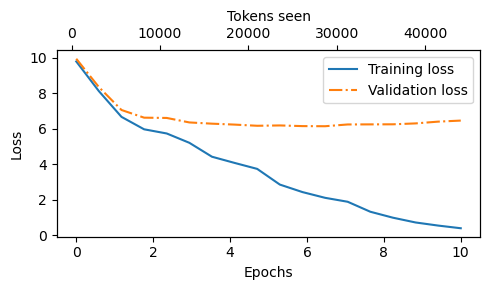

In [116]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")

    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()                  
    ax2.plot(tokens_seen, train_losses, alpha=0)    
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

#### 5. Text Generation Strategies

In [117]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [118]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
 )

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


#### Temperature Scaling

In [119]:
# To understand the next-token generation process, let's use a small vocab.
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}


In [120]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
 )

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [121]:
# To implement a probabilistic sampling process, we can now replace argmax with the multinomial function in PyTorch.
torch.manual_seed(123) 
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

"""
As a result, "forward" will still be printed as it is still the most likely next word. 
However, this time, it will not be the case ALL the time. Let's test this out.
"""

def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]

    sampled_ids = torch.bincount(torch.tensor(sample))
    
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

forward
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


#### Temperature Scaling

In [122]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

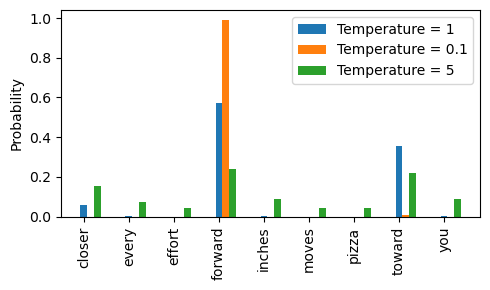

In [ ]:
# Visualise the diversity of outputs depending on the temperature value.
temperatures = [1, 0.1, 5]

scaled_probas = [softmax_with_temperature(next_token_logits, T)
        for T in temperatures]

x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], 
           bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# **STAGE THREE PART 1 - CLASSIFIER**

# **STAGE THREE PART 2 - PERSONAL ASSISTANT**